In [1]:
pip install prophet


In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

In [17]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1918 entries, 1013 to 160
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1918 non-null   datetime64[ns]
 1   Local Route   1918 non-null   int64         
 2   Light Rail    1918 non-null   int64         
 3   Peak Service  1918 non-null   int64         
 4   Rapid Route   1918 non-null   int64         
 5   School        1918 non-null   int64         
 6   Other         1898 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 119.9 KB
None
                      Date   Local Route    Light Rail  Peak Service  \
count                 1918   1918.000000   1918.000000   1918.000000   
mean   2022-02-13 12:00:00   9891.395203   7195.446298    179.581335   
min    2019-07-01 00:00:00      1.000000      0.000000      0.000000   
25%    2020-10-22 06:00:00   3044.500000   4463.500000      0.000000   
50%    2022

In [19]:
print(df.isnull().sum())

Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64


In [6]:
df.fillna(method='ffill', inplace=True)
local_df = df[['Date', 'Local Route']].rename(columns={'Date': 'ds', 'Local Route': 'y'})

<ipython-input-6-9cc693500660>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [7]:
model = Prophet()
model.fit(local_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/3h0utxoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/f3qo52b3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26042', 'data', 'file=/tmp/tmp1fgrbyl9/3h0utxoy.json', 'init=/tmp/tmp1fgrbyl9/f3qo52b3.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_modeldy3y98xe/prophet_model-20250603045100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
future = model.make_future_dataframe(periods=7)

In [9]:
forecast = model.predict(future)

<ipython-input-13-b37846f18380>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


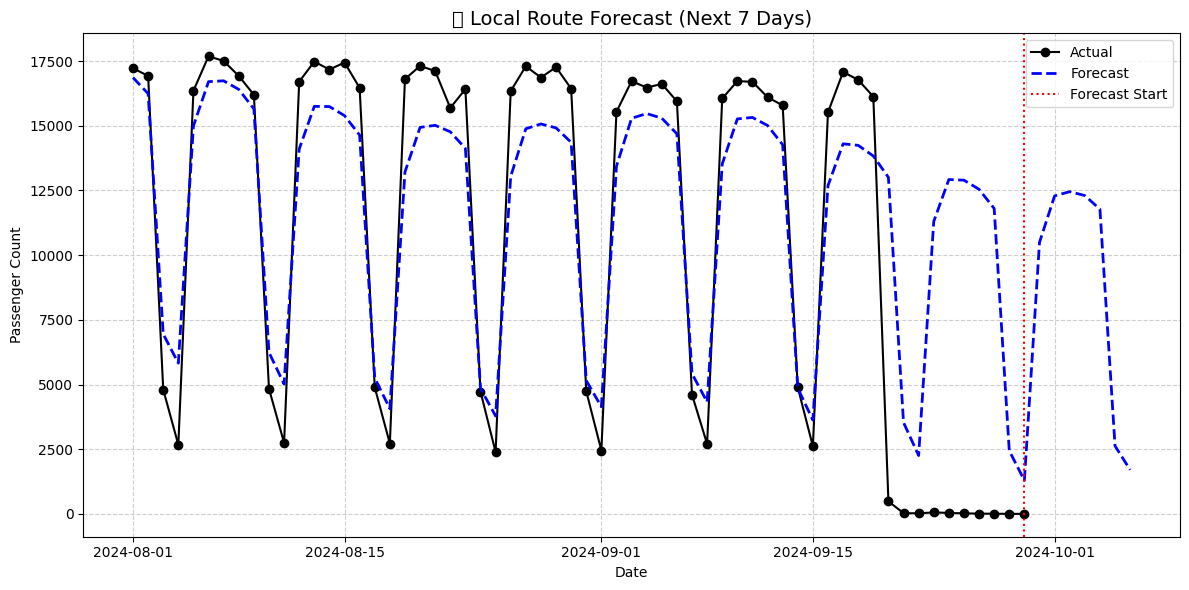

,ds,yhat
1918,2024-09-30,10495.099677
1919,2024-10-01,12290.212671
1920,2024-10-02,12454.564899
1921,2024-10-03,12304.106031
1922,2024-10-04,11774.630519
1923,2024-10-05,2626.683795
1924,2024-10-06,1701.722160


In [13]:
import matplotlib.pyplot as plt
forecast_merged = local_df.merge(forecast[['ds', 'yhat']], on='ds', how='right')
plot_df = forecast_merged.tail(67)
actuals = plot_df[plot_df['y'].notnull()]
forecasted = plot_df[plot_df['y'].isnull()]

plt.figure(figsize=(12, 6))
plt.plot(actuals['ds'], actuals['y'], label='Actual', color='black', marker='o')
plt.plot(plot_df['ds'], plot_df['yhat'], label='Forecast', color='blue', linestyle='--', linewidth=2)
plt.axvline(x=actuals['ds'].iloc[-1], color='red', linestyle=':', label='Forecast Start')
plt.title('📊 Local Route Forecast (Next 7 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
forecast[['ds', 'yhat']].tail(7)


In [26]:
for route in routes:
    data = df[['Date', route]].rename(columns={'Date': 'ds', route: 'y'}).dropna()
    model = Prophet(interval_width=0.4, changepoint_prior_scale=0.01)
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.fit(data)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)  # clip negatives

    forecast_next7 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7).reset_index(drop=True)
    forecast_next7.rename(columns={
        'yhat': f'{route}_forecast',
        'yhat_lower': f'{route}_lower',
        'yhat_upper': f'{route}_upper'
    }, inplace=True)

    if all_forecasts.empty:
        all_forecasts['Date'] = forecast_next7['ds']

    all_forecasts[f'{route}_forecast'] = forecast_next7[f'{route}_forecast']
    all_forecasts[f'{route}_lower'] = forecast_next7[f'{route}_lower']
    all_forecasts[f'{route}_upper'] = forecast_next7[f'{route}_upper']

    all_forecasts[f'{route}_range'] = all_forecasts.apply(
        lambda row: f"{int(row[f'{route}_lower'])} - {int(row[f'{route}_upper'])}", axis=1
    )


INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/rnj3gdjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/bpupw60o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82770', 'data', 'file=/tmp/tmp1fgrbyl9/rnj3gdjw.json', 'init=/tmp/tmp1fgrbyl9/bpupw60o.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_modelm_1g62sa/prophet_model-20250603054702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'we

In [27]:
range_cols = [col for col in all_forecasts.columns if col.endswith('_range')]
print(all_forecasts[['Date'] + range_cols])

        Date Local Route_range Light Rail_range Peak Service_range  \
0 2024-09-30      8991 - 12630      7808 - 9847          218 - 308   
1 2024-10-01     11068 - 14369     8759 - 11041          263 - 344   
2 2024-10-02     10986 - 14623     8984 - 11077          260 - 352   
3 2024-10-03     10839 - 14209     8844 - 11009          231 - 320   
4 2024-10-04     10279 - 14017     8818 - 11066          178 - 274   
5 2024-10-05       1109 - 5064      5329 - 7564             0 - 73   
6 2024-10-06        382 - 3875      4015 - 6093             0 - 64   

  Rapid Route_range School_range  
0     12918 - 16982   432 - 2005  
1     15138 - 19084   733 - 2433  
2     14776 - 18954   775 - 2359  
3     14958 - 19127   756 - 2359  
4     13896 - 18462   660 - 2217  
5      6145 - 10448     0 - -900  
6       4747 - 9083     0 - -789  


INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/d1fm7fm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/mhe9m0s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87127', 'data', 'file=/tmp/tmp1fgrbyl9/d1fm7fm9.json', 'init=/tmp/tmp1fgrbyl9/mhe9m0s8.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_model2tk8od_t/prophet_model-20250603055300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


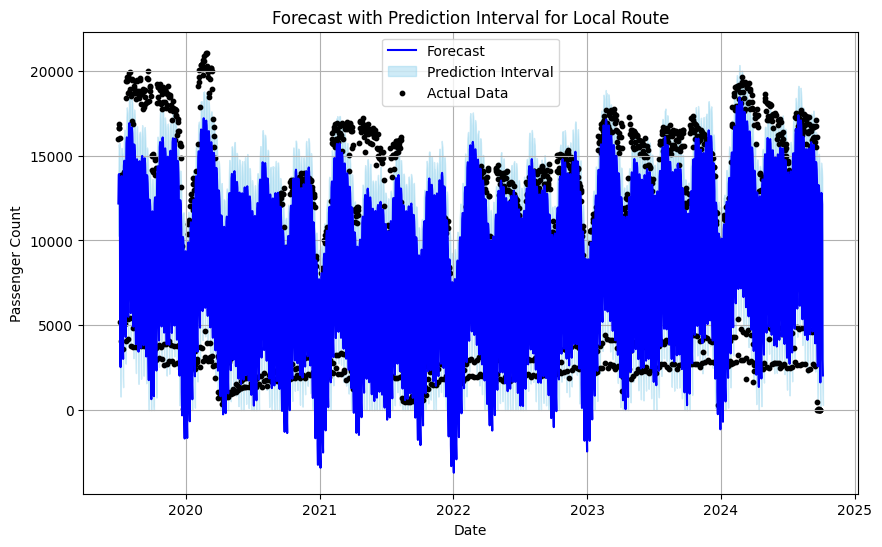

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/u63ijzhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/2muvk1b7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58491', 'data', 'file=/tmp/tmp1fgrbyl9/u63ijzhm.json', 'init=/tmp/tmp1fgrbyl9/2muvk1b7.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_model3jd7u7v3/prophet_model-20250603055301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


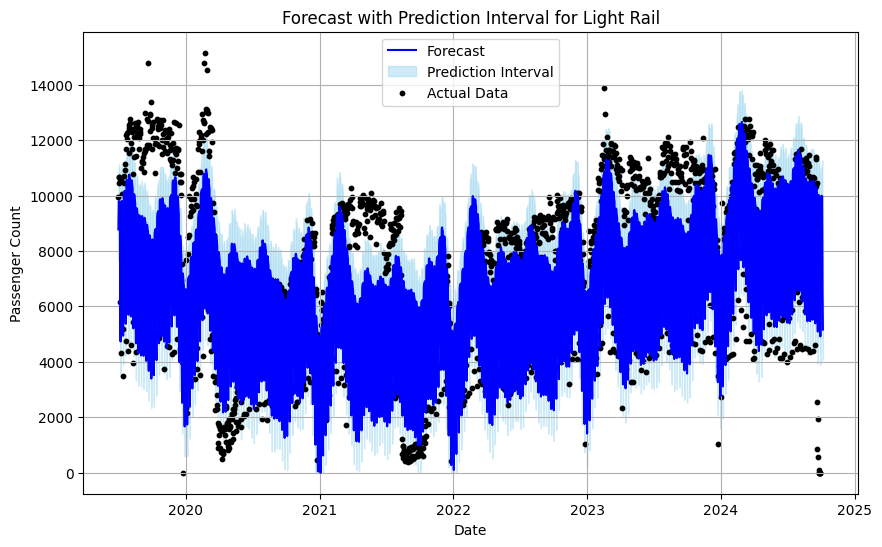

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/_g6iovg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/dqusk96h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12605', 'data', 'file=/tmp/tmp1fgrbyl9/_g6iovg2.json', 'init=/tmp/tmp1fgrbyl9/dqusk96h.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_modelkp2l2fds/prophet_model-20250603055302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


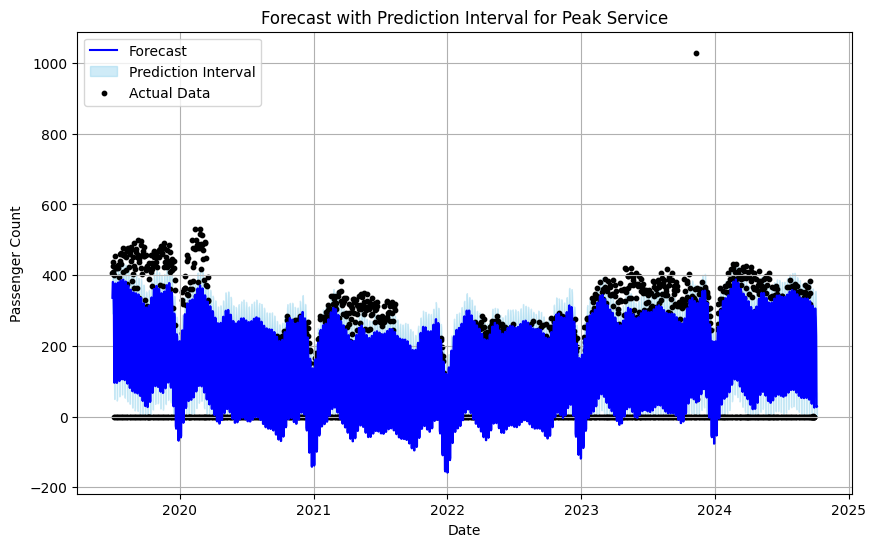

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/k1f96hpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/ix80hlj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10244', 'data', 'file=/tmp/tmp1fgrbyl9/k1f96hpe.json', 'init=/tmp/tmp1fgrbyl9/ix80hlj4.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_modelfvdms15d/prophet_model-20250603055303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


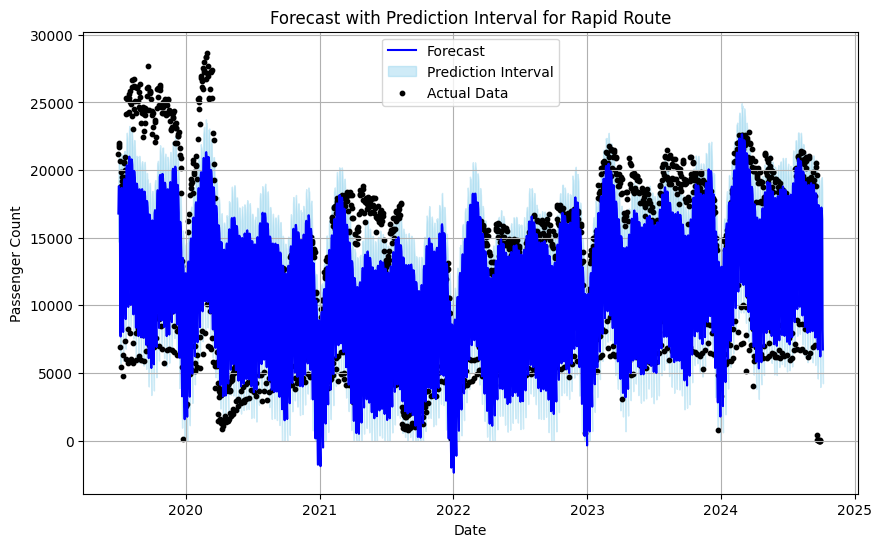

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/06qkg8pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fgrbyl9/_lvaebdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28605', 'data', 'file=/tmp/tmp1fgrbyl9/06qkg8pl.json', 'init=/tmp/tmp1fgrbyl9/_lvaebdz.json', 'output', 'file=/tmp/tmp1fgrbyl9/prophet_model05d4o_qk/prophet_model-20250603055304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


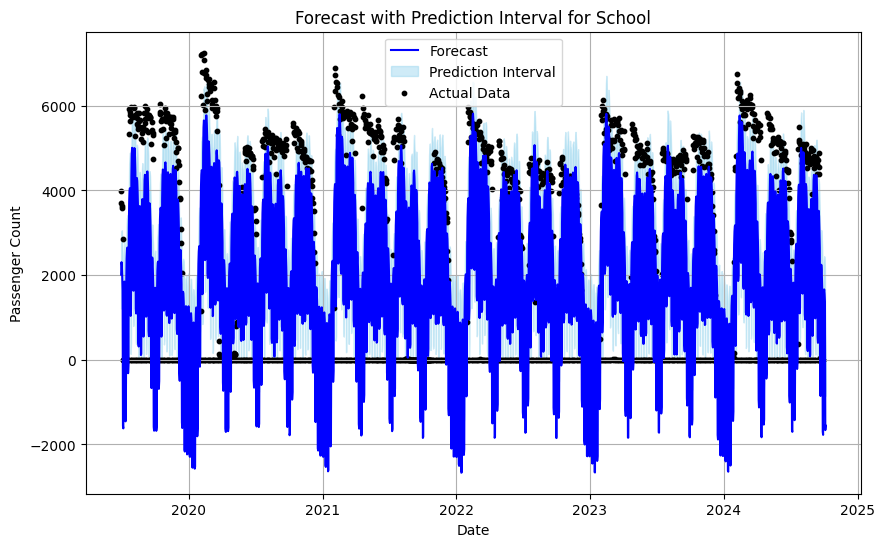

In [28]:
import matplotlib.pyplot as plt

for route in routes:
    data = df[['Date', route]].rename(columns={'Date': 'ds', route: 'y'}).dropna()
    model = Prophet(interval_width=0.4, changepoint_prior_scale=0.01)
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.fit(data)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)  # clip negatives

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
    plt.fill_between(forecast['ds'],
                     forecast['yhat_lower'],
                     forecast['yhat_upper'],
                     color='skyblue', alpha=0.4, label='Prediction Interval')
    plt.scatter(data['ds'], data['y'], color='black', s=10, label='Actual Data')

    plt.title(f"Forecast with Prediction Interval for {route}")
    plt.xlabel("Date")
    plt.ylabel("Passenger Count")
    plt.legend()
    plt.grid(True)
    plt.show()
